# Introduction

Here, we predict the cumulative number of confirmed COVID19 cases/fatalities in various countries using the data of COVID infection/fatalities gathered from 22th January to 31st March by using the ARIMA model for time series analysis.

# Importing Necessary Packages

In [132]:
import pandas as pd
import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.simplefilter('ignore')
train=pd.read_csv(r"../input/covid19-global-forecasting-week-2/train.csv")
test=pd.read_csv(r"../input/covid19-global-forecasting-week-2/test.csv")

In [133]:
train.sample(6)

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
20149,28760,NaN,United Kingdom,2020-03-21,5018.0,233.0
10392,14833,NaN,Kyrgyzstan,2020-02-23,0.0,0.0
4620,6601,Jiangxi,China,2020-01-22,2.0,0.0
15424,22025,NaN,Togo,2020-02-15,0.0,0.0
9099,12970,NaN,Haiti,2020-03-31,15.0,0.0
1749,2470,NaN,Belize,2020-03-31,3.0,0.0


As can be seen, there are 6 columns of which we focus on 'Country_Region', 'Date', 'ConfirmedCases', and 'Fatalities'. There're 20580 entries/rows in total.

In [134]:
test.sample(6)

,ForecastId,Province_State,Country_Region,Date
12239,12240,Gibraltar,United Kingdom,2020-04-15
5040,5041,NaN,France,2020-03-28
2899,2900,Jilin,China,2020-04-06
9099,9100,NaN,Sudan,2020-04-14
12453,12454,NaN,Uzbekistan,2020-04-14
6302,6303,NaN,"Korea, South",2020-04-12


In [135]:
print(train.shape)
print(test.shape)

(20580, 6)
(12642, 4)


In [136]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20580 entries, 0 to 20579
Data columns (total 6 columns):
Id                20580 non-null int64
Province_State    8750 non-null object
Country_Region    20580 non-null object
Date              20580 non-null object
ConfirmedCases    20580 non-null float64
Fatalities        20580 non-null float64
dtypes: float64(2), int64(1), object(3)
memory usage: 964.8+ KB


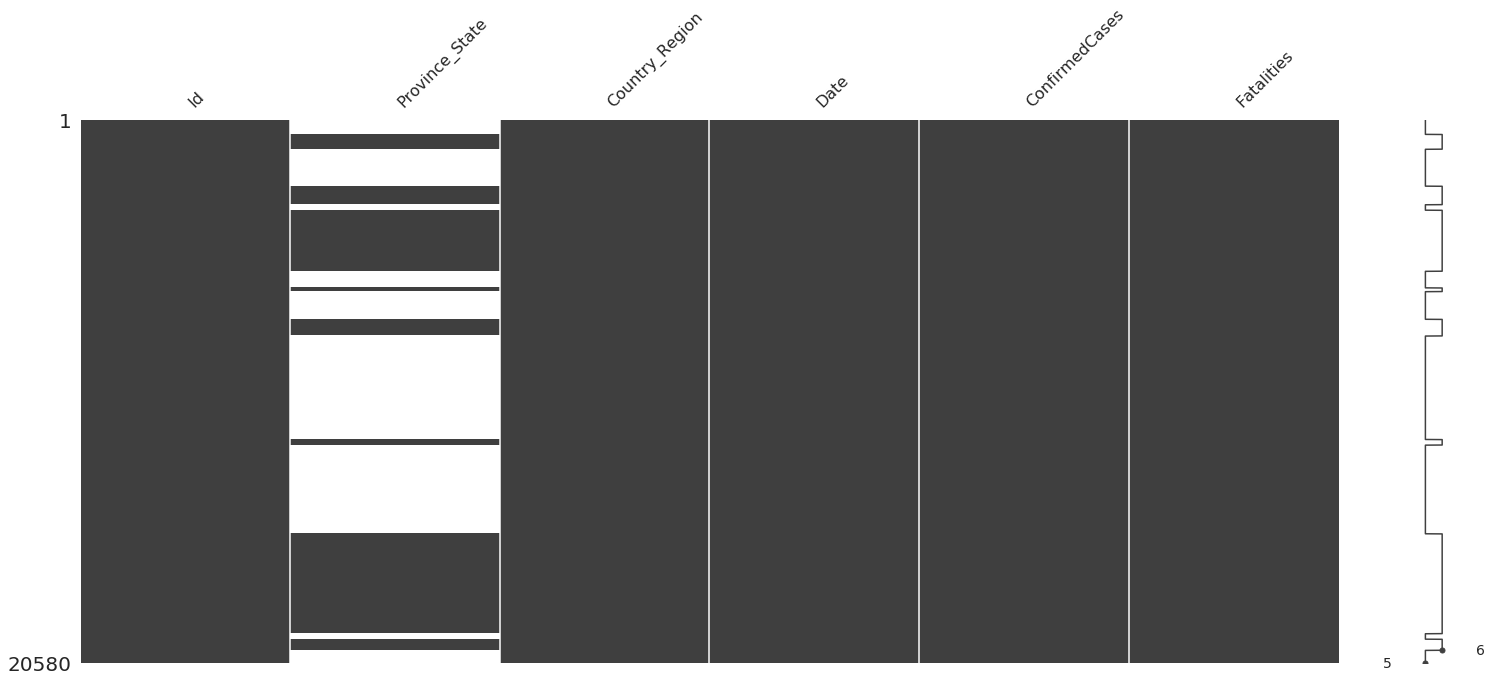

In [137]:
import missingno as msno
msno.matrix(train)


From 'missingno' plot of the columns, we find only Province_State has quite a few missing values. However, in this article we're not using that.

# EDA

In [138]:
def top10(data, label):

    
    df = data.fillna('NA').groupby(['Country_Region','Province_State','Date'])[label].sum().groupby(['Country_Region','Province_State']).max().sort_values() \
                              .groupby(['Country_Region']).sum().sort_values(ascending = False)

    
    highest10 = pd.DataFrame(df).head(10)
    highest10
    
    return highest10

top10countries_confirmedCases = top10(train,'ConfirmedCases' )
top10countries_confirmedCases

,ConfirmedCases
Country_Region,
US,188018.0
Italy,105792.0
Spain,95923.0
China,82280.0
Germany,71808.0
France,52827.0
Iran,44605.0
United Kingdom,25471.0
Switzerland,16605.0


In [139]:
top10countries_fatalities = top10(train,'Fatalities' )
top10countries_fatalities

,Fatalities
Country_Region,
Italy,12428.0
Spain,8464.0
US,3871.0
France,3532.0
China,3309.0
Iran,2898.0
United Kingdom,1793.0
Netherlands,1040.0
Germany,775.0


From the data, we determine the top 10 nations with the highest infections and fatalities. We visualize these findings for better understanding.

In [140]:
def barPlotTopCountries(data, label):
    
    fig = px.bar(data, x=data.index, y=label, labels={'x':'Country'},
                 color=label, color_continuous_scale=px.colors.sequential.Magenta)
    fig.update_layout(title_text=label+' COVID-19 by country')
    fig.show()
    
barPlotTopCountries(top10countries_confirmedCases,'ConfirmedCases' )
barPlotTopCountries(top10countries_fatalities,'Fatalities' )

From the above bar plots, US has the most Confirmed cases followed by italy. Again, Italy has the most fatalities followed by Spain. Overall developed countries from Europe dominiate both the graphs. Now for US, Italy, China, Spain, Germany, and India, let's observe the daily changes in COVID cases and fatalities for the month of March.

In [141]:
def dailyCasePlot(country, label,date):
    df_by_date = pd.DataFrame(train.fillna('NA').groupby(['Country_Region','Date'])[label].sum().sort_values().reset_index())

    fig = px.bar(df_by_date.loc[(df_by_date['Country_Region'] == country) &(df_by_date.Date >= date)].sort_values(label,ascending = False), 
                 x='Date', y=label, color=label, color_continuous_scale=px.colors.sequential.Teal)
    fig.update_layout(title_text=label+' COVID-19 per day in '+country)
    fig.show()
dailyCasePlot('US', 'ConfirmedCases', '2020-03-01')
dailyCasePlot('US', 'Fatalities','2020-03-01')

The US has seen considerable increase in the number of confirmed cases and fatalities after March 20.

In [142]:
dailyCasePlot('Italy', 'ConfirmedCases', '2020-03-01')
dailyCasePlot('Italy', 'Fatalities', '2020-03-01')

Compared to US, Italy witnessed a gradual increase in the number of cases and fatalities in March.

In [143]:
dailyCasePlot('China', 'ConfirmedCases', '2020-01-01')
dailyCasePlot('China', 'Fatalities', '2020-01-01')

In China's case, the number of fatalities and confirmed cases has stabilized by March.

In [144]:
dailyCasePlot('Germany', 'ConfirmedCases', '2020-03-01')
dailyCasePlot('Germany', 'Fatalities', '2020-03-01')

In [145]:
dailyCasePlot('Spain', 'ConfirmedCases', '2020-03-01')
dailyCasePlot('Spain', 'Fatalities', '2020-03-01')

The cases of Germany and Spain present similar patterns of infections and fatalities where after March 15, we find a gradual increase.

In [146]:
dailyCasePlot('India', 'ConfirmedCases', '2020-03-01')
dailyCasePlot('India', 'Fatalities', '2020-03-01')

The number of cases and fatalities is lower than the other countries shown above. Despite the increasing trend, we observe that some days the infection or fatality depicts a spike.

# Time evaluation

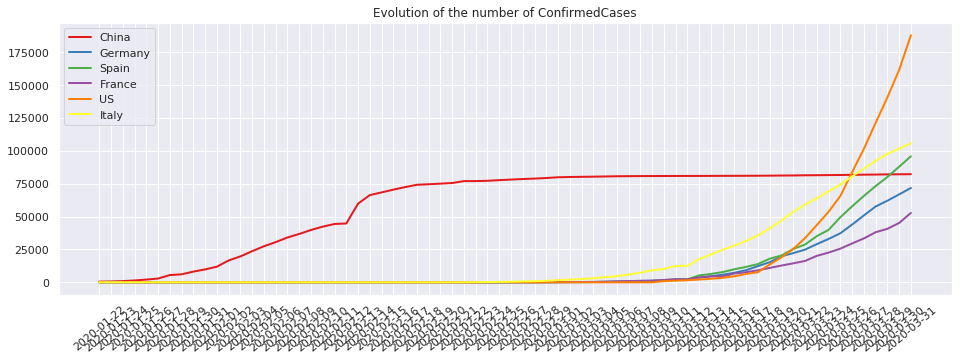

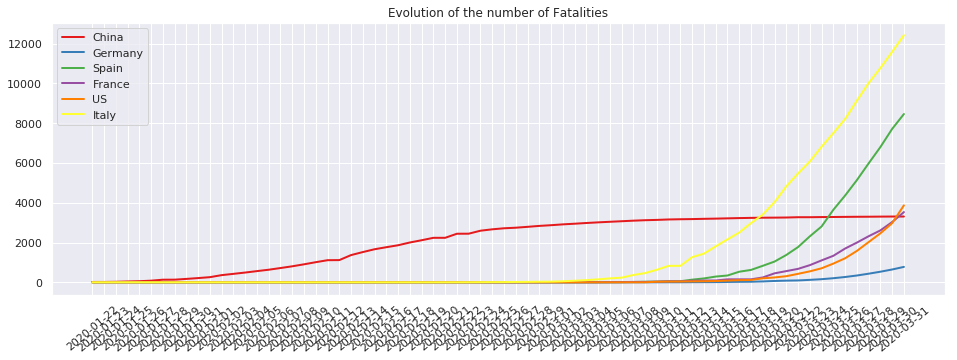

In [147]:
df=train.groupby(['Date','Country_Region']).agg('sum').reset_index()

def plot_country_comparison(label, *arguments):
    f, ax=plt.subplots(figsize=(16,5))
    countries = arguments
    for country in arguments:
        country=df.loc[(df['Country_Region']==country)]
        plt.plot(country['Date'],country[label],linewidth=2)
        plt.xticks(rotation=40)
        plt.legend(countries)
        ax.set(title='Evolution of the number of ' + label)
        
plot_country_comparison('ConfirmedCases','China', 'Germany','Spain','France','US', 'Italy')
plot_country_comparison('Fatalities','China', 'Germany','Spain','France','US', 'Italy')


From the comparisons, we observe China's numbers, though initially larger, have later stabilized. Infection in the European nations mentioned have seen gradual upward trend in March. US, however, has witnessed a sharp/exponential increase in infection cases in March. Italy leads the other nations when it comes to fatalities with Germany showing the least amount of increase in fatalities.

For our time series infection/fatalities predictions, we use moving/rolling average to smooth out short-term fluctuations and highlight longer-term trends. This can be seen from the graphs of moving average time series graphs of US, China, Italy, Germany, and Spain.

# ARIMA

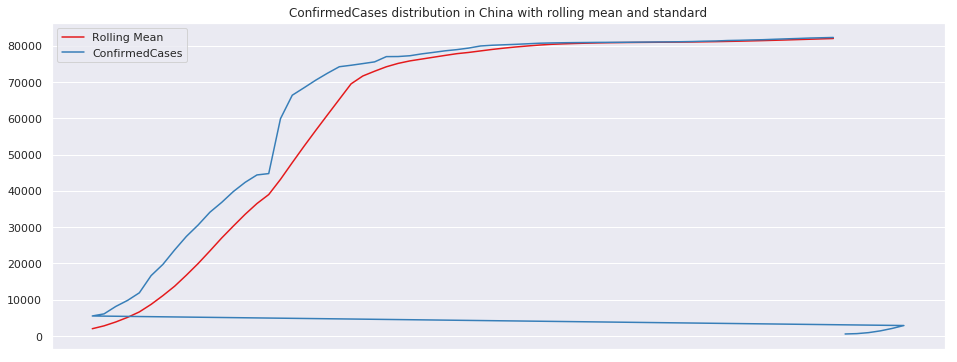

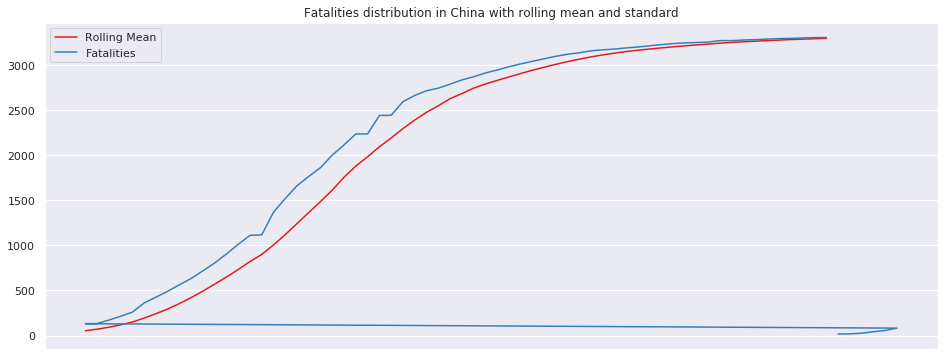

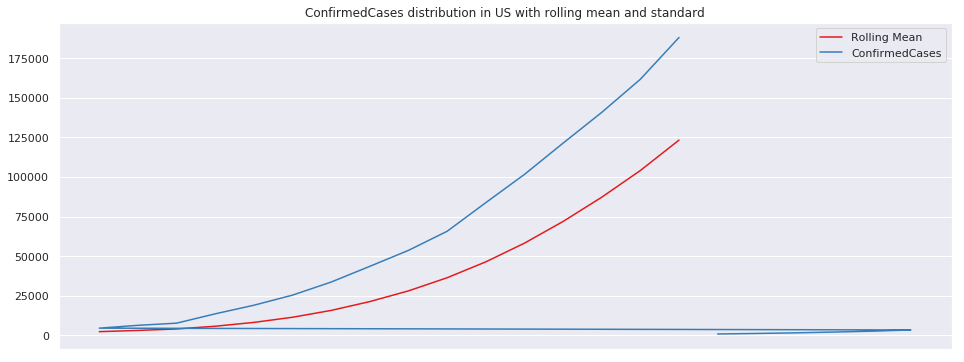

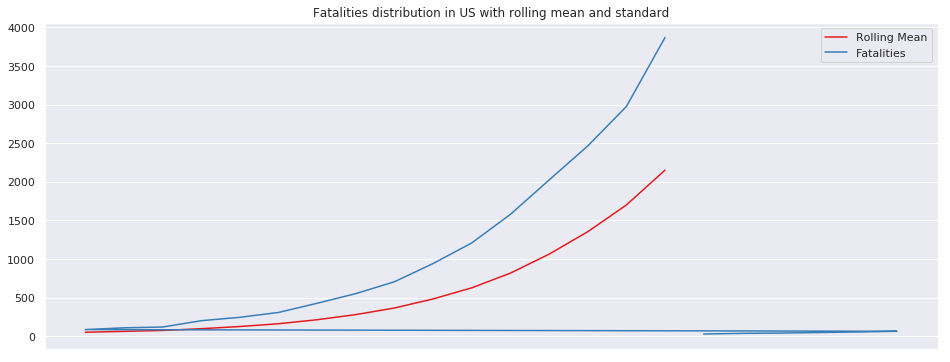

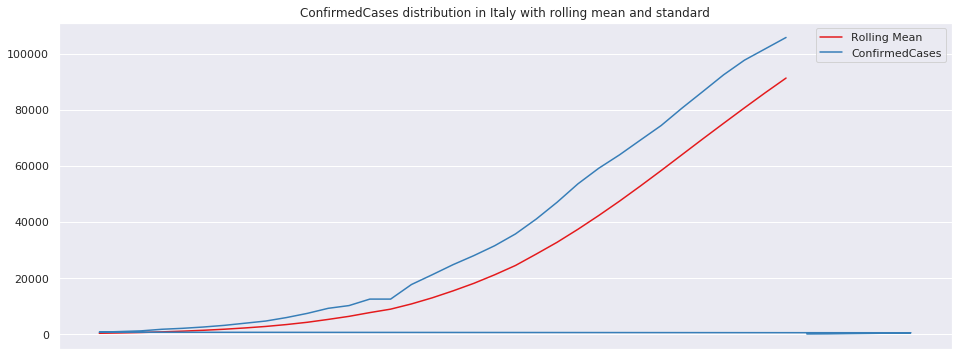

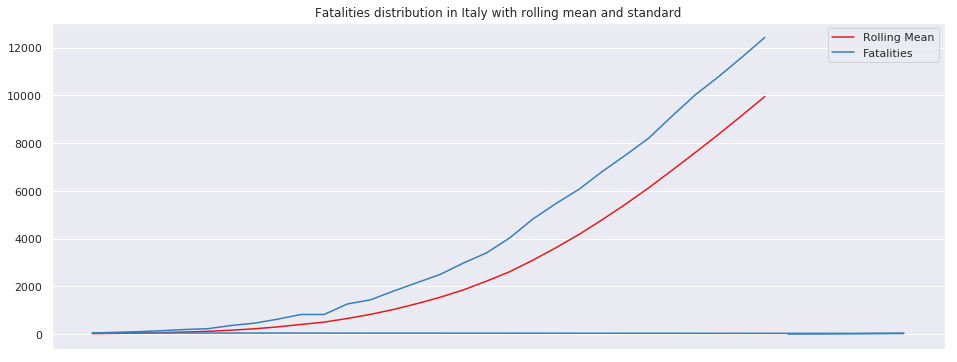

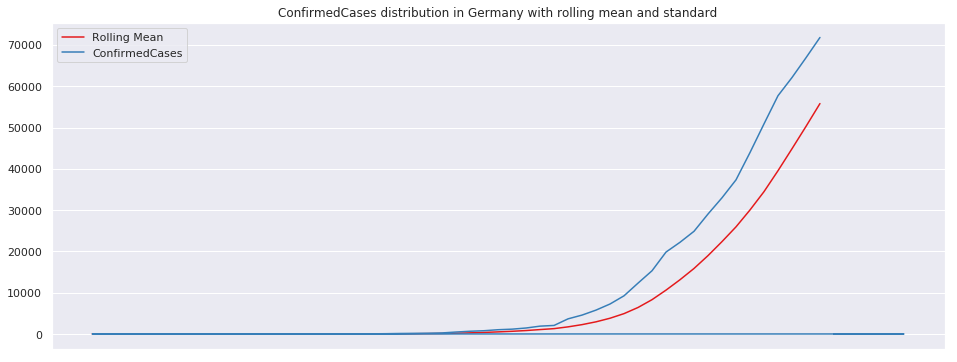

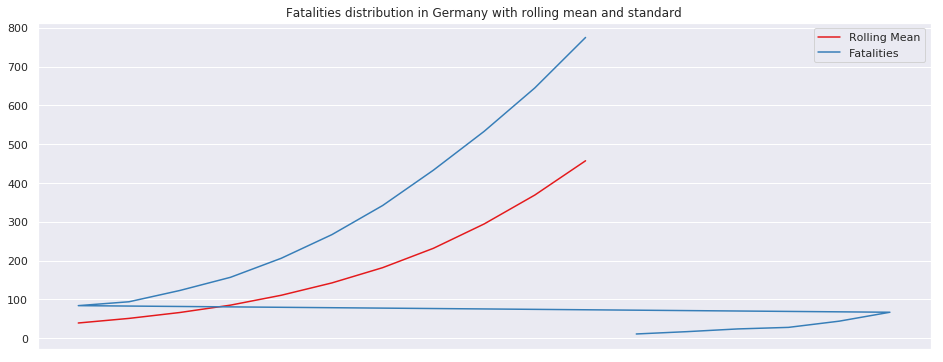

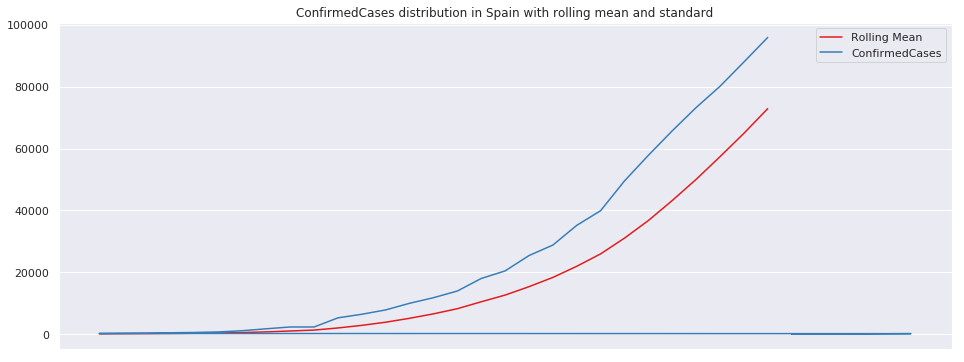

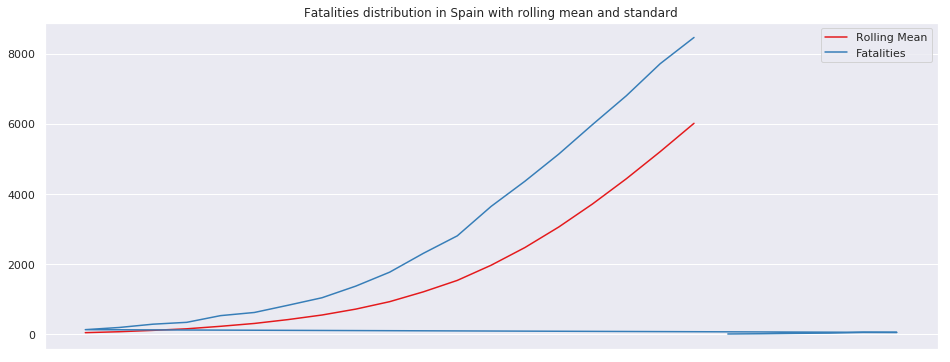

In [148]:


sns.set(palette = 'Set1',style='darkgrid')
#Function for making a time series on a designated country and plotting the rolled mean and standard 


def roll_v2(tempTs, case='ConfirmedCases'):
    return (tempTs.rolling(window=4,center=False).mean().dropna())

def rollPlot_v2(tempTs,country,case='ConfirmedCases'):
    plt.figure(figsize=(16,6))
    plt.plot(tempTs.rolling(window=7,center=False).mean().dropna(),label='Rolling Mean')
    plt.plot(tempTs[case])
    
    plt.legend()
    plt.title(case+' distribution in %s with rolling mean and standard' %country)
    plt.xticks([])



def tempTimeSeries(country, case = 'ConfirmedCases'):
    ts=df.loc[(df['Country_Region']==country)]  
    ts=ts[['Date',case]]
    ts=ts.set_index('Date')
    ts.astype('int64')
    a=len(ts.loc[(ts[case]>=10)])
    ts=ts[-a:]
    return ts

def createTimeSeries(country):
    
    tempTsCase = tempTimeSeries(country)
    tempTsFatalities = tempTimeSeries(country,'Fatalities')
    timeSeriesCases=roll_v2(tempTsCase)
    timeSeriesFatalities = roll_v2(tempTsFatalities, 'Fatalities')
    
    rollPlot_v2(tempTsCase, country)
    rollPlot_v2(tempTsFatalities, country, 'Fatalities')
    return timeSeriesCases, timeSeriesFatalities
timeSeriesChinaCases, timeSeriesChinaFatalities =createTimeSeries('China')
timeSeriesUSCases, timeSeriesUSFatalities =createTimeSeries('US')
timeSeriesItalyCases, timeSeriesItalyFatalities =createTimeSeries('Italy')
timeSeriesGermanyCases, timeSeriesGermanyFatalities =createTimeSeries('Germany')
timeSeriesSpainCases, timeSeriesSpainFatalities =createTimeSeries('Spain')

Let's decompose the created time series data, to present the trend, seasonality and residuals of infection/fatalities time series of China, US, Spain, Italy, Germany.

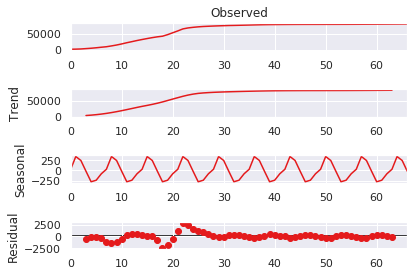

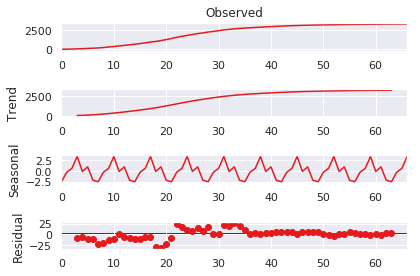

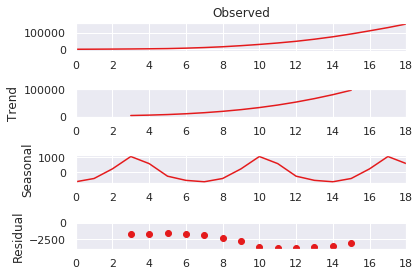

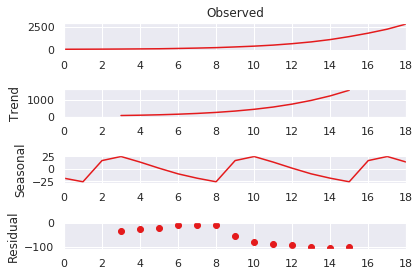

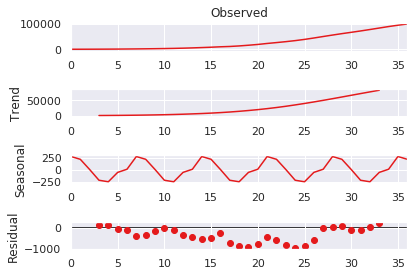

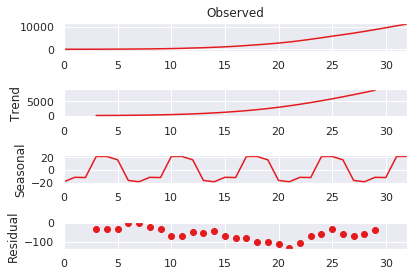

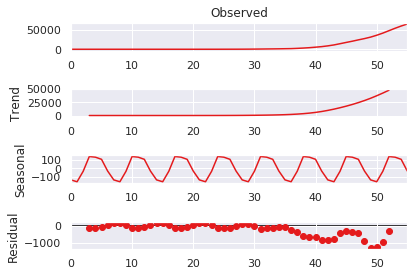

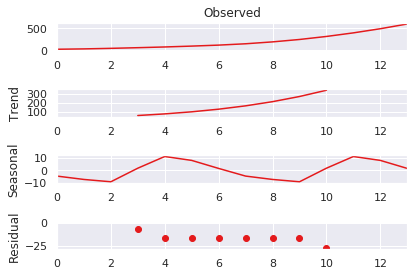

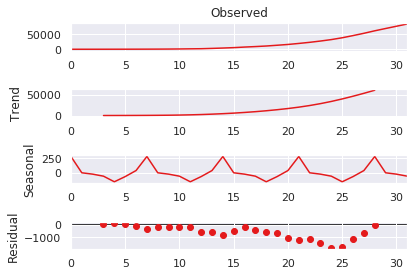

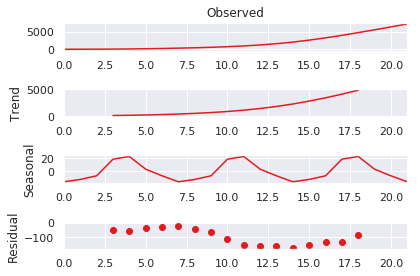

In [149]:
#Decomposing the ts to find its properties


def decomposition_timeseries(timeSeries):
    fig=sm.tsa.seasonal_decompose(timeSeries.values,freq=7).plot()
def draw_decomposition_graphs():
    #China
    decomposition_timeseries(timeSeriesChinaCases)
    decomposition_timeseries(timeSeriesChinaFatalities)

    #US
    decomposition_timeseries(timeSeriesUSCases)
    decomposition_timeseries(timeSeriesUSFatalities)

    #Italy
    decomposition_timeseries(timeSeriesItalyCases)
    decomposition_timeseries(timeSeriesItalyFatalities)

    #Germany
    decomposition_timeseries(timeSeriesGermanyCases)
    decomposition_timeseries(timeSeriesGermanyFatalities)

    #Spain
    decomposition_timeseries(timeSeriesSpainCases)
    decomposition_timeseries(timeSeriesSpainFatalities)
draw_decomposition_graphs()

Given the time-series we are using at the moment possess trend and seasonality, they aren't stationary. However, to make predictions the data is required to be stationary. To make time series stationary we need to difference data. This differencing is taken care by the ARIMA algorithm. To check whether the time-series is stationary, we use Dickey-Fuller test where the P-value<0.005 means the data is stationary. Otherwise, the data is non-stationary. For the 10 time series dataset we created, applying the test, we find nearly all of them are non-stationary with P-value>0.005. 

In order to implement the ARIMA model on the time series data, we need to determine the p factor(number of significant lags in Partial Auto Correlation) of AR, d: the number of times to difference, and q factor(number of significant lags in Auto Correlation) of MA. For this reason, we need to plot the ACF and PACF of the time series data.

In [150]:
#Function to check the stationarity of the time serie using Dickey fuller test


def stationarity(ts):
    print('Results of Dickey-Fuller Test:')
    test = adfuller(ts, autolag='AIC')
    results = pd.Series(test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    #for i,val in test[4].items():
        #results['Critical Value (%s)'%i] = val
    print ('P-Value: '+str(results['p-value']))


def checkStationarity(case_ts, fatal_ts):
    
    tsC=case_ts['ConfirmedCases'].values
    stationarity(tsC)
    tsF=fatal_ts['Fatalities'].values
    stationarity(tsF)
checkStationarity(timeSeriesChinaCases, timeSeriesChinaFatalities)
checkStationarity(timeSeriesUSCases, timeSeriesUSFatalities)
checkStationarity(timeSeriesItalyCases, timeSeriesItalyFatalities)
checkStationarity(timeSeriesGermanyCases, timeSeriesGermanyFatalities)
checkStationarity(timeSeriesSpainCases, timeSeriesSpainFatalities)

Results of Dickey-Fuller Test:
P-Value: 0.008437485035674023
Results of Dickey-Fuller Test:
P-Value: 0.11072924334381884
Results of Dickey-Fuller Test:
P-Value: 0.6054221987938584
Results of Dickey-Fuller Test:
P-Value: 0.5489140523266745
Results of Dickey-Fuller Test:
P-Value: 4.666040922678857e-05
Results of Dickey-Fuller Test:
P-Value: 0.045048818177230145
Results of Dickey-Fuller Test:
P-Value: 0.9401054307830131
Results of Dickey-Fuller Test:
P-Value: 0.9984470159795278
Results of Dickey-Fuller Test:
P-Value: 0.00211413718788017
Results of Dickey-Fuller Test:
P-Value: 6.658802600781108e-07


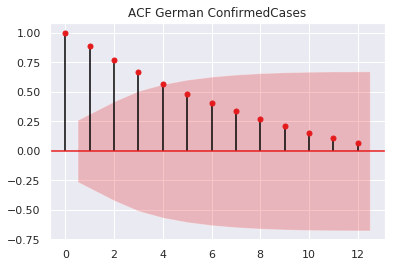

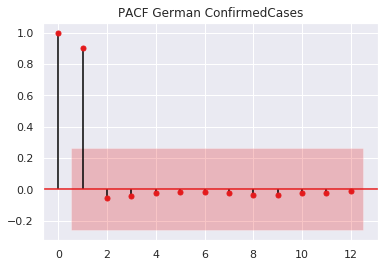

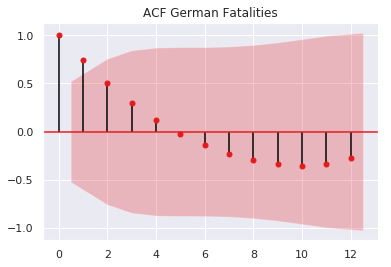

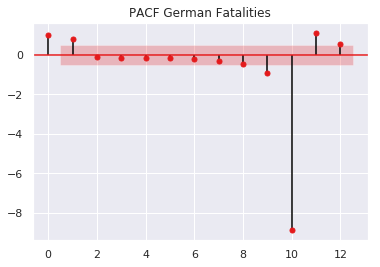

In [151]:


def corr(ts,country):
    plot_acf(ts,lags=12,title="ACF "+country)
    plot_pacf(ts,lags=12,title="PACF "+country)
    

#For China
corr(timeSeriesGermanyCases,'German ConfirmedCases')
corr(timeSeriesGermanyFatalities, 'German Fatalities')

Different ACF/PACF plots show different amounts of significant lags. As such, to train our model we have to grid search to find the appropriate values of p,d,q. We search within a range of [0,6] to find the best parameter values. For choosing the best set of parameters, we choose the model with the lowest AIC metric. While training, we use 85% of the data for model-training. The rest 15% is used for testing and prediction. For each time series two plots are drawn. One is to show the difference between true(red) and predicted(green) values. The other one is forecasting the future values of cases/fatalities of a country.

Best Parameters(p,d,q) for China ConfirmedCase: (0, 2, 4)
Best Parameters(p,d,q) for China Fatalities: (0, 2, 5)
Best Parameters(p,d,q) for US ConfirmedCase: (1, 2, 0)
Best Parameters(p,d,q) for US Fatalities: (0, 2, 3)
Best Parameters(p,d,q) for Italy ConfirmedCase: (0, 2, 2)
Best Parameters(p,d,q) for Italy Fatalities: (0, 2, 2)
Best Parameters(p,d,q) for Germany ConfirmedCase: (0, 2, 4)
Best Parameters(p,d,q) for Germany Fatalities: (0, 2, 4)
Best Parameters(p,d,q) for Spain ConfirmedCase: (0, 2, 3)
Best Parameters(p,d,q) for Spain Fatalities: (0, 2, 3)
{'China': (0, 2, 4), 'US': (1, 2, 0), 'Italy': (0, 2, 2), 'Germany': (0, 2, 4), 'Spain': (0, 2, 3)}
{'China': (0, 2, 5), 'US': (0, 2, 3), 'Italy': (0, 2, 2), 'Germany': (0, 2, 4), 'Spain': (0, 2, 3)}


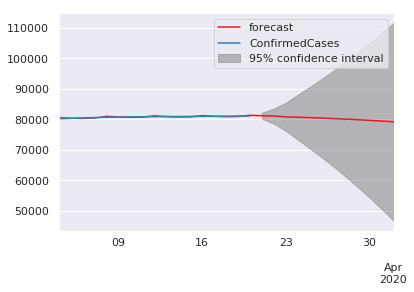

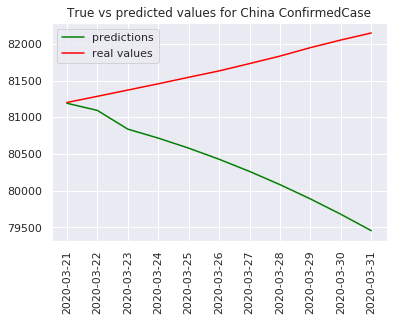

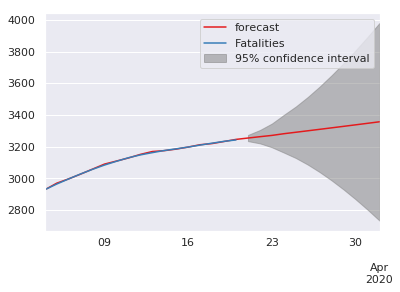

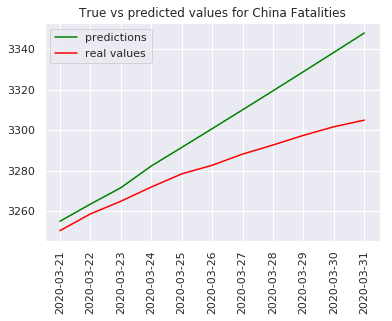

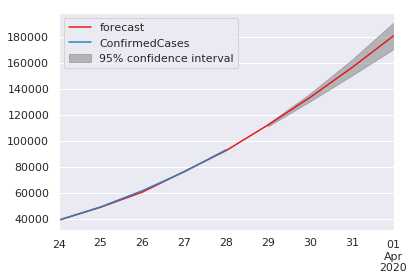

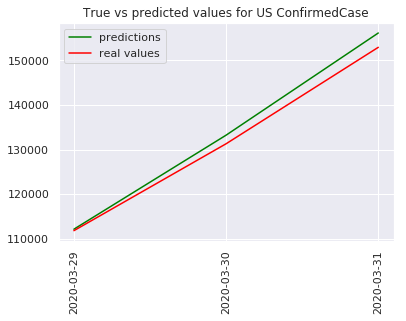

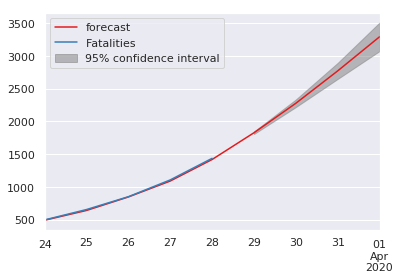

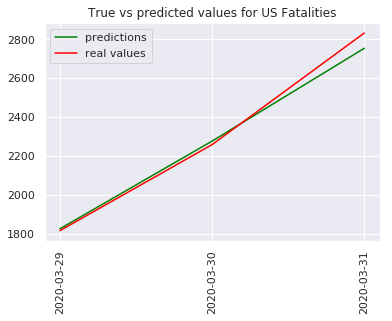

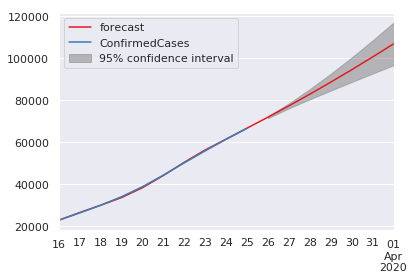

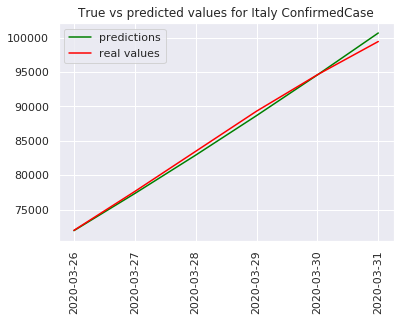

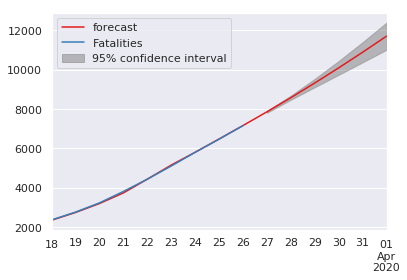

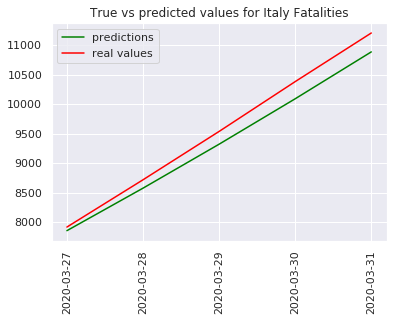

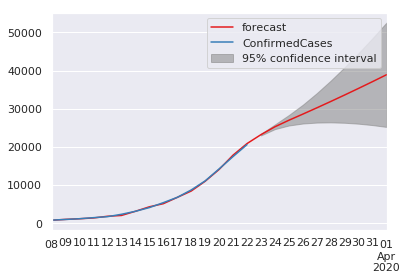

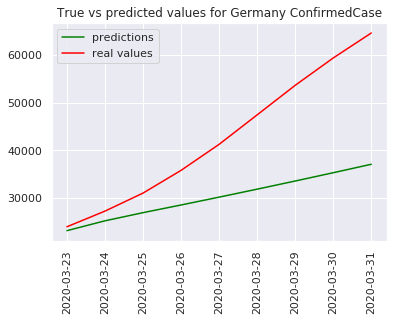

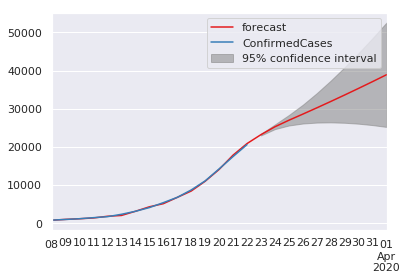

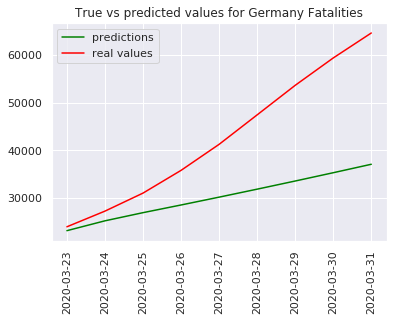

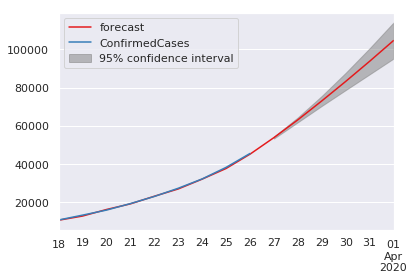

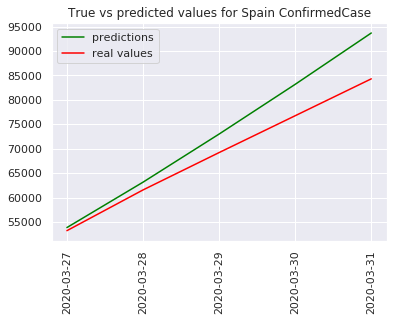

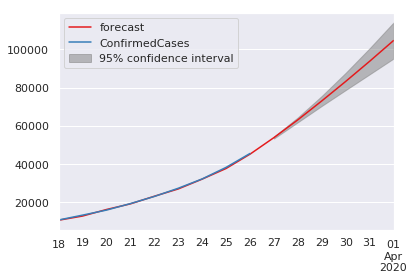

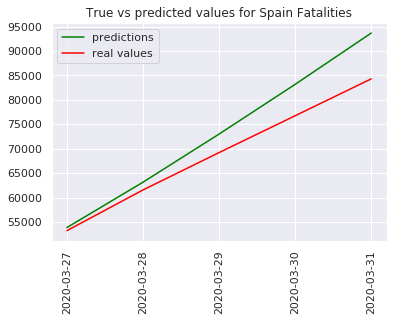

In [157]:




def split(timeseries):
    #splitting 85%/15% because of little amount of data
    size = int(len(timeseries) * 0.85)
    train= timeseries[:size]
    test = timeseries[size:]
    return(train,test)


    
def plot_pred_vs_true(pred, test,country, case):
    f,ax=plt.subplots()
    plt.plot(pred,c='green', label= 'predictions')
    plt.plot(test, c='red',label='real values')
    plt.xticks(rotation=90)
    plt.legend()
    plt.title('True vs predicted values for '+country+' '+case)

def forecast(model, timeseries):
    result = model.fit()
    result.plot_predict(start=int(len(timeseries) * 0.7), end=int(len(timeseries) * 1.2))
    return result

def plots_result(model, ts, test, country, case):
    
    result = forecast(model,ts)
    pred=result.forecast(steps=len(test))[0]
    #Plotting results
    plot_pred_vs_true(pred, test,country, case)
  



#Arima modeling for ts
def arima(timeseries, country, case):
    
    train,test = split(timeseries)

    p=d=q=range(0,6)
    lowest_aic=99999
    pdq=list(itertools.product(p,d,q))
    
    #Determining the best parameters
    for var in pdq:
        try:
            model = ARIMA(train, order=var)
            result = model.fit()

            if (result.aic<=lowest_aic) :
                lowest_aic=result.aic
                best_parameters=var
        except:
            continue

    
            
    #Modeling
    model = ARIMA(train, order=best_parameters)
    
    plots_result(model,train,test, country, case)
    
    

    print('Best Parameters(p,d,q) for '+country+' '+case+ ': '+ str(best_parameters))
    return best_parameters
    

case_parameter_dict = {}
fatal_parameter_dict = {}

'''
timeSeriesChinaCases, timeSeriesChinaFatalities =createTimeSeries('China')
timeSeriesUSCases, timeSeriesUSFatalities =createTimeSeries('US')
timeSeriesItalyCases, timeSeriesItalyFatalities =createTimeSeries('Italy')
timeSeriesGermanyCases, timeSeriesGermanyFatalities =createTimeSeries('Germany')
timeSeriesSpainCases, timeSeriesSpainFatalities =createTimeSeries('Spain')
'''

p1 = arima(timeSeriesChinaCases,'China', 'ConfirmedCase')
p2 = arima(timeSeriesChinaFatalities,'China', 'Fatalities')
case_parameter_dict['China'] = p1
fatal_parameter_dict['China'] = p2

p1 = arima(timeSeriesUSCases,'US', 'ConfirmedCase')
p2 = arima(timeSeriesUSFatalities,'US', 'Fatalities')
case_parameter_dict['US'] = p1
fatal_parameter_dict['US'] = p2

p1 = arima(timeSeriesItalyCases,'Italy', 'ConfirmedCase')
p2 = arima(timeSeriesItalyFatalities,'Italy', 'Fatalities')
case_parameter_dict['Italy'] = p1
fatal_parameter_dict['Italy'] = p2

p1 = arima(timeSeriesGermanyCases,'Germany', 'ConfirmedCase')
p2 = arima(timeSeriesGermanyCases,'Germany', 'Fatalities')
case_parameter_dict['Germany'] = p1
fatal_parameter_dict['Germany'] = p2

p1 = arima(timeSeriesSpainCases,'Spain', 'ConfirmedCase')
p2 = arima(timeSeriesSpainCases,'Spain', 'Fatalities')
case_parameter_dict['Spain'] = p1
fatal_parameter_dict['Spain'] = p2

print(case_parameter_dict)
print(fatal_parameter_dict)


In [159]:
df_case_parameter_dict = pd.DataFrame.from_dict(case_parameter_dict, orient='index',columns=['p', 'd', 'q'])
df_case_parameter_dict.head(10)

,p,d,q
China,0,2,4
US,1,2,0
Italy,0,2,2
Germany,0,2,4
Spain,0,2,3


In [160]:
df_fatal_parameter_dict = pd.DataFrame.from_dict(fatal_parameter_dict, orient='index',columns=['p', 'd', 'q'])
df_fatal_parameter_dict.head(10)

,p,d,q
China,0,2,5
US,0,2,3
Italy,0,2,2
Germany,0,2,4
Spain,0,2,3


From analyzing the parameters for best models, we see, except 1, the models don't need the p-parameter representing significant PACF singnificant lags. The value of d is 2 in all the models meaning we do 2 differencing in all the models.

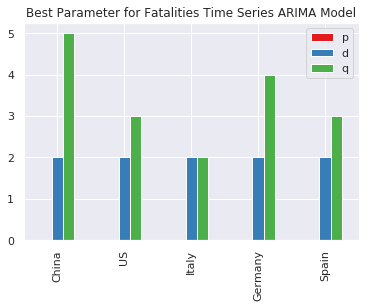

In [162]:
df_fatal_parameter_dict.plot(kind="bar",title="Best Parameter for Fatalities Time Series ARIMA Model")
df_case_parameter_dict.plot(kind="bar",title="Best Parameter for ConfirmedCases Time Series ARIMA Model")